In [1]:
import numpy as np
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LinearRegression, HuberRegressor, RANSACRegressor
from sklearn.model_selection import cross_validate 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import sklearn.cluster as clut

Index
<br>
1 - Loading and understanding the data
<br>

2 - Global functions
<br>

3 - Clustering to separate the data (not successful)
<br>

4 - Robust Regression methods to separate the data
<br>
4.1 - Huber Regression
<br>
4.2 - Chosen model: RANSAC method followed by Linear Regression
<br>

5 - Submission file

In [2]:
# load data

xtrain = np.load("X_train_regression2.npy")
ytrain = np.load("y_train_regression2.npy")

xtest = np.load("X_test_regression2.npy")


print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)

(100, 4)
(100, 1)
(1000, 4)


In [3]:
# train std

xtrain_std = np.std(xtrain, axis=0)
print(xtrain_std)

# train mean

xtrain_mean = np.mean(xtrain, axis=0)
print(xtrain_mean)

[1.03755925 1.03105139 1.01919535 1.01031081]
[-0.02060709  0.04891162 -0.13595219 -0.21733056]


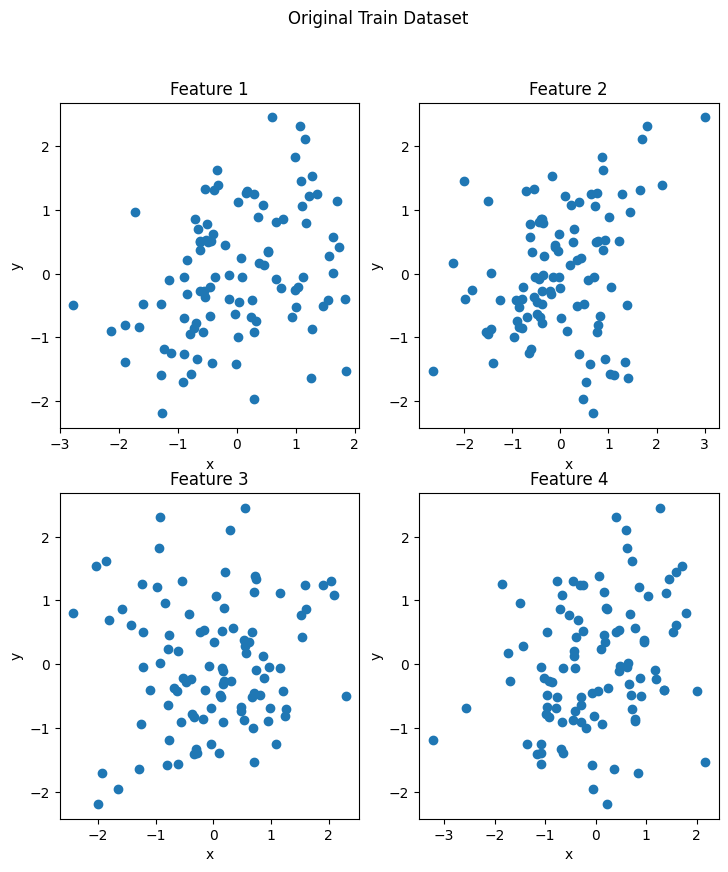

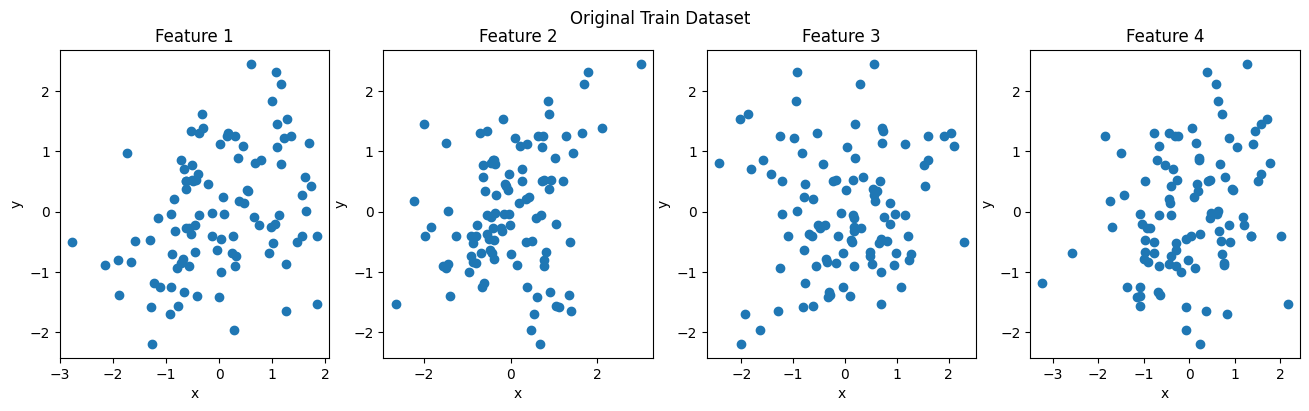

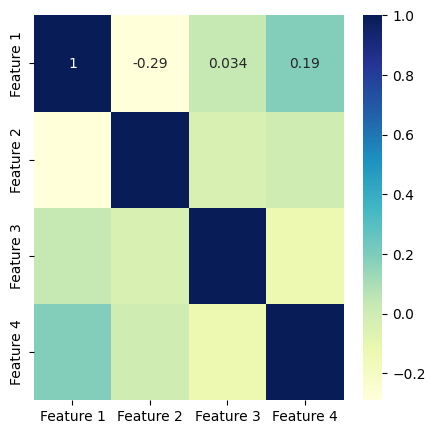

In [52]:
# normalize training data

xtrain_norm = (xtrain - np.mean(xtrain, axis=0)) / np.std(xtrain, axis=0)
ytrain_norm = (ytrain - np.mean(ytrain, axis=0)) / np.std(ytrain, axis=0)

#normalized scatter plot for each feature

fig, axs = plt.subplots(2, 2, figsize=(8.5,9.3))
axs[0, 0].scatter(xtrain_norm[:,0],ytrain_norm)
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('y')
axs[0, 0].set_title('Feature 1')
axs[0, 1].scatter(xtrain_norm[:,1],ytrain_norm)
axs[0,1].set_xlabel('x')
axs[0,1].set_ylabel('y')
axs[0, 1].set_title('Feature 2')
axs[1, 0].scatter(xtrain_norm[:,2],ytrain_norm)
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('y')
axs[1, 0].set_title('Feature 3')
axs[1, 1].scatter(xtrain_norm[:,3],ytrain_norm)
axs[1,1].set_xlabel('x')
axs[1,1].set_ylabel('y')
axs[1, 1].set_title('Feature 4')
fig.suptitle('Original Train Dataset')



fig, axs = plt.subplots(1, 4, figsize=(16,4))
axs[0].scatter(xtrain_norm[:,0],ytrain_norm)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('Feature 1')
axs[1].scatter(xtrain_norm[:,1],ytrain_norm)
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_title('Feature 2')
axs[2].scatter(xtrain_norm[:,2],ytrain_norm)
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_title('Feature 3')
axs[3].scatter(xtrain_norm[:,3],ytrain_norm)
axs[3].set_xlabel('x')
axs[3].set_ylabel('y')
axs[3].set_title('Feature 4')
fig.suptitle('Original Train Dataset')



# heat map of correlation matrix between features

plt.figure(figsize=(5,5))
corr = np.corrcoef(xtrain_norm.T)
sns.heatmap(corr, 
            xticklabels=['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4'],
            yticklabels=['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4'],
            annot=True, cmap="YlGnBu")
plt.show()







## Global functions

In [5]:
#Ridge alphas
def ridgebestalpha(x,y,nalph):
    n_alphas = nalph
    alphas = np.logspace(-10, 2, n_alphas)

    param_grid = {"alpha": alphas}
    modelridge = Ridge(fit_intercept=True)

    search = GridSearchCV(estimator=modelridge, param_grid=param_grid, n_jobs=2, scoring='neg_mean_squared_error', cv=LeaveOneOut())
    search.fit(x, y)

    print(f"The best parameters found are: {search.best_params_}")

    best_alpharidge = search.best_params_['alpha']
    return search

In [6]:
def ridgescores(x,y,search):
    print(f"The mean CV score of the model with the best alpha (using LOOCV) is: {-search.best_score_:.3f}")

    mseridge = cross_val_score(search.best_estimator_, xtrain, ytrain, cv=5, scoring='neg_mean_squared_error')
    print(f"The MSE score of the model using the best alpha with CV k=5 is: {np.mean(-mseridge):.3f}")


    # get r2

    scores = cross_val_score(search.best_estimator_, xtrain, ytrain, cv=5, scoring='r2')
    print(f"The mean r2 (test) score of the best model is: {scores.mean():.3f}")

    # predict

    ypred = search.best_estimator_.predict(x)

    # get train r2

    r2 = r2_score(y, ypred)
    print(f"The r2 (train) score of the best model is: {r2:.3f}")

In [7]:
def lassoalpha(x,y,numalphas):
    n_alphas = numalphas
    alphas = np.logspace(-10, 2, n_alphas)

    param_grid = {"alpha": alphas}
    lassomodel = Lasso(fit_intercept=True)

    searchlasso = GridSearchCV(estimator=lassomodel, param_grid=param_grid, n_jobs=2, scoring='neg_mean_squared_error', cv=LeaveOneOut())
    searchlasso.fit(x, y)

    print(f"The best parameters found is: {searchlasso.best_params_}")

    best_alpha_lasso = searchlasso.best_params_['alpha']
    return searchlasso

In [8]:
def lassocoef(x,y,search):
    lassomodel = Lasso(alpha = search.best_params_['alpha'], fit_intercept=True)
    lassomodel.fit(x, y)
    print(f"The coefficients for the best alpha are: {lassomodel.coef_}")

In [9]:
def lassostats(x,y,search):
    print("Lasso Statistics\n")

    print(f"The mean CV score of the model using the best alpha and LOOCV is: {-search.best_score_:.3f}")

    mselasso = cross_val_score(search.best_estimator_, x, y, cv=5, scoring='neg_mean_squared_error')
    print(f"The MSE score of the model using the best alpha with CV k=11 is: {np.mean(-mselasso):.3f}")

    # get r2

    scores = cross_val_score(search.best_estimator_, x, y, cv=5, scoring='r2')
    print(f"The mean r2 (test) score of the best model is: {scores.mean():.3f}")

    # predict

    ypred = search.best_estimator_.predict(x)

    # get train r2

    r2 = r2_score(y, ypred)
    print(f"The r2 (train) score of the best model is: {r2:.3f}")

In [10]:
def reg(x,y):
    regmodel = LinearRegression()
    reg = regmodel.fit(x,y)
    return reg

In [11]:
def regcoefs(reg):
    print(reg.coef_)
    return

In [12]:
def regstats(x,y,reg):
    print("Regression Statistics\n")

    msereg = cross_val_score(reg, x, y, cv=LeaveOneOut(), scoring='neg_mean_squared_error')
    print(f"The MSE score of the model is: {np.mean(-msereg):.3f}")

    msereg = cross_val_score(reg, x, y, cv=5, scoring='neg_mean_squared_error')
    print(f"The MSE score of the model (using k=5) is: {np.mean(-msereg):.3f}")


    # get r2

    scores = cross_val_score(reg, x, y, cv=5, scoring='r2')
    print(f"The mean r2 (test) score of the best model is: {scores.mean():.3f}")

    # predict

    ypred = reg.predict(x)

    # get train r2

    r2 = r2_score(y, ypred)
    print(f"The r2 (train) score of the best model is: {r2:.3f}")

In [38]:
model_tot = reg(xtrain,ytrain)
print(regstats(xtrain,ytrain,model_tot))

Regression Statistics

The MSE score of the model is: 1.335
The MSE score of the model (using k=5) is: 1.396
The mean r2 (test) score of the best model is: 0.077
The r2 (train) score of the best model is: 0.301
None


### Clustering to divide the data into subsets

In [13]:
# KMEAN Clustering

kmean = clut.KMeans(2, max_iter=1000)
kmeanfit = kmean.fit(xtrain, ytrain)
print(kmeanfit.labels_)
clutpred = kmeanfit.predict(xtrain)
print('soma: ', np.sum(clutpred))
kmean.cluster_centers_

c:\Users\beama\OneDrive\Documents\uni\4 ano\ML\mlenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[1 1 1 0 1 1 1 1 0 1 0 1 0 1 1 0 0 0 1 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1
 1 0 1 1 1 1 0 1 1 1 1 0 1 1 0 0 0 1 0 1 1 0 0 0 1 1 0 1 1 1 1 0 1 1 0 1 1
 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 0 1 1 0 1 0 1 0 0 1]
soma:  64


array([[ 0.74270869, -0.70673373,  0.53367549, -0.46782136],
       [-0.44997221,  0.47396212, -0.51261776, -0.07642949]])

In [14]:
xtrain1 = xtrain[clutpred == 0]
ytrain1 = ytrain[clutpred == 0]
print(xtrain1.shape)
print(100-np.sum(clutpred))

xtrain2 = xtrain[clutpred == 1]
ytrain2 = ytrain[clutpred == 1]
print(xtrain2.shape)
print(np.sum(clutpred))

(36, 4)
36
(64, 4)
64


Text(0.5, 0.98, 'Scatter Plot of Subset 1 and 2 (separated using KMeans)')

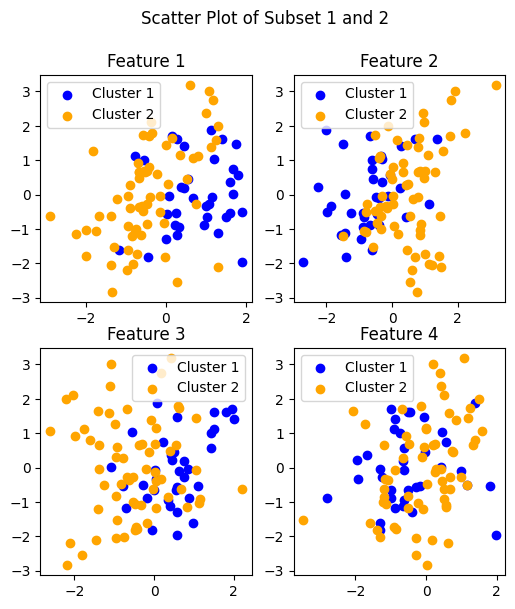

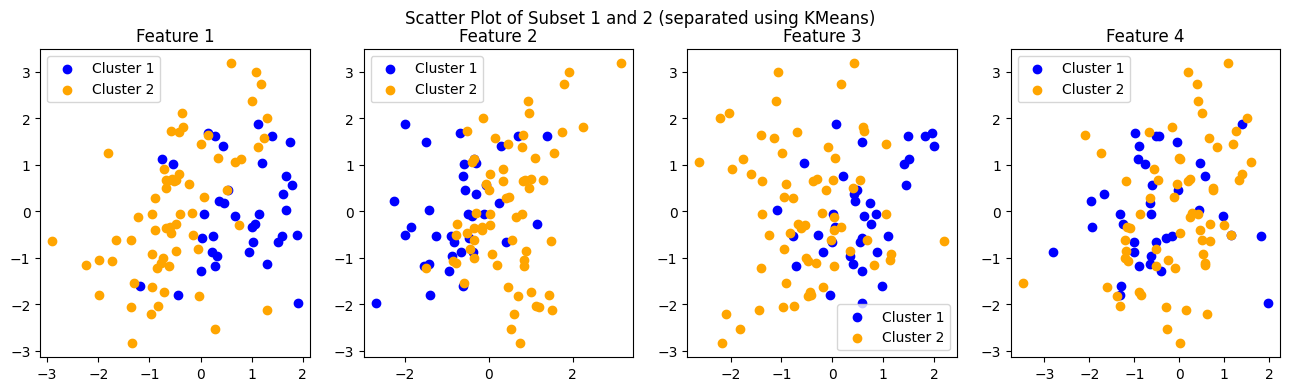

In [53]:
# scatter plot in the same subplot for both clusters with different colors

fig, axs = plt.subplots(2, 2,figsize=(6,6.5))
axs[0, 0].scatter(xtrain1[:,0],ytrain1, color='blue', label='Cluster 1')
axs[0, 0].scatter(xtrain2[:,0],ytrain2, color='orange', label='Cluster 2')
axs[0,0].legend()
axs[0, 0].set_title('Feature 1')
axs[0, 1].scatter(xtrain1[:,1],ytrain1, color='blue', label='Cluster 1')
axs[0, 1].scatter(xtrain2[:,1],ytrain2, color='orange', label='Cluster 2')
axs[0,1].legend()
axs[0, 1].set_title('Feature 2')
axs[1, 0].scatter(xtrain1[:,2],ytrain1, color='blue', label='Cluster 1')
axs[1, 0].scatter(xtrain2[:,2],ytrain2, color='orange', label='Cluster 2')
axs[1,0].legend()
axs[1, 0].set_title('Feature 3')
axs[1, 1].scatter(xtrain1[:,3],ytrain1, color='blue', label='Cluster 1')
axs[1, 1].scatter(xtrain2[:,3],ytrain2, color='orange', label='Cluster 2')
axs[1,1].legend()
axs[1, 1].set_title('Feature 4')
plt.suptitle('Scatter Plot of Subset 1 and 2')

# same plot but one line and for columns of plots 

fig, axs = plt.subplots(1, 4,figsize=(16,4))
axs[0].scatter(xtrain1[:,0],ytrain1, color='blue', label='Cluster 1')
axs[0].scatter(xtrain2[:,0],ytrain2, color='orange', label='Cluster 2')
axs[0].legend()
axs[0].set_title('Feature 1')
axs[1].scatter(xtrain1[:,1],ytrain1, color='blue', label='Cluster 1')
axs[1].scatter(xtrain2[:,1],ytrain2, color='orange', label='Cluster 2')
axs[1].legend()
axs[1].set_title('Feature 2')
axs[2].scatter(xtrain1[:,2],ytrain1, color='blue', label='Cluster 1')
axs[2].scatter(xtrain2[:,2],ytrain2, color='orange', label='Cluster 2')
axs[2].legend()
axs[2].set_title('Feature 3')
axs[3].scatter(xtrain1[:,3],ytrain1, color='blue', label='Cluster 1')
axs[3].scatter(xtrain2[:,3],ytrain2, color='orange', label='Cluster 2')
axs[3].legend()
axs[3].set_title('Feature 4')
plt.suptitle('Scatter Plot of Subset 1 and 2 (separated using KMeans)')



In [54]:
# mean and std of each cluster

print('Cluster 1 mean: ', np.mean(xtrain1, axis=0))
print('Cluster 1 std: ', np.std(xtrain1, axis=0))
print('Cluster 2 mean: ', np.mean(xtrain2, axis=0))
print('Cluster 2 std: ', np.std(xtrain2, axis=0))


Cluster 1 mean:  [ 0.74270869 -0.70673373  0.53367549 -0.46782136]
Cluster 1 std:  [0.78900178 0.89362769 0.74275228 1.03148617]
Cluster 2 mean:  [-0.44997221  0.47396212 -0.51261776 -0.07642949]
Cluster 2 std:  [0.90543451 0.84260957 0.95845606 0.97018569]


In [16]:
# Best Alphas for each Kmean cluster

search1 = ridgebestalpha(xtrain1,ytrain1,200)
search2 = ridgebestalpha(xtrain2,ytrain2,200)

The best parameters found are: {'alpha': 24.945081352303166}
The best parameters found are: {'alpha': 9.437878277775352}


In [17]:
ridgescores(xtrain1,ytrain1,search1)
ridgescores(xtrain2,ytrain2,search2)

The mean CV score of the model with the best alpha (using LOOCV) is: 1.068
The MSE score of the model using the best alpha with CV k=5 is: 1.394
The mean r2 (test) score of the best model is: 0.111
The r2 (train) score of the best model is: 0.206
The mean CV score of the model with the best alpha (using LOOCV) is: 1.465
The MSE score of the model using the best alpha with CV k=5 is: 1.387
The mean r2 (test) score of the best model is: 0.099
The r2 (train) score of the best model is: 0.379


In [18]:
search1lasso = lassoalpha(xtrain1,ytrain1,200)
search2lasso = lassoalpha(xtrain2,ytrain2,200)

The best parameters found is: {'alpha': 0.1683180353330955}
The best parameters found is: {'alpha': 1.3200884008314168e-10}


In [19]:
lassocoef(xtrain1,ytrain1,search1lasso)
lassocoef(xtrain2,ytrain2,search2lasso)

The coefficients for the best alpha are: [0.         0.11179042 0.22630581 0.        ]
The coefficients for the best alpha are: [0.7515679  0.39061523 0.18687229 0.2839531 ]


In [20]:
lassostats(xtrain1,ytrain1,search1lasso)
lassostats(xtrain2,ytrain2,search2lasso)

Lasso Statistics

The mean CV score of the model using the best alpha and LOOCV is: 1.153
The MSE score of the model using the best alpha with CV k=11 is: 1.063
The mean r2 (test) score of the best model is: -0.018
The r2 (train) score of the best model is: 0.154
Lasso Statistics

The mean CV score of the model using the best alpha and LOOCV is: 1.488
The MSE score of the model using the best alpha with CV k=11 is: 1.578
The mean r2 (test) score of the best model is: 0.055
The r2 (train) score of the best model is: 0.386


In [21]:
reg1 = reg(xtrain1,ytrain1)
reg2 = reg(xtrain2,ytrain2)

In [22]:
regcoefs(reg1)
regcoefs(reg2)

[[0.22809157 0.26662489 0.53557598 0.13835832]]
[[0.7515679  0.39061523 0.18687229 0.2839531 ]]


In [23]:
regstats(xtrain1,ytrain1,reg1)
regstats(xtrain2,ytrain2,reg2)

Regression Statistics

The MSE score of the model is: 1.206
The MSE score of the model (using k=5) is: 1.092
The mean r2 (test) score of the best model is: -0.202
The r2 (train) score of the best model is: 0.271
Regression Statistics

The MSE score of the model is: 1.488
The MSE score of the model (using k=5) is: 1.578
The mean r2 (test) score of the best model is: 0.055
The r2 (train) score of the best model is: 0.386


Interpreting one of the probabilistic models' data as outliers, we can use robust linear regression algorithms to divide the data and then optimize linear regression models for each subset of the train data.

#### Using Huber regression to split the train datasets

In [58]:

ytrain_f = ytrain.ravel()
huber = HuberRegressor(epsilon=1.2, fit_intercept=True).fit(xtrain,ytrain_f) # the smaller the epsilon the more robust it is to outliers
index1 = np.where(huber.outliers_ == True)
index2 = np.where(huber.outliers_ == False)

subset1h = xtrain[index1]
subset2h = xtrain[index2]

ytrain1h = ytrain[index1]
ytrain2h = ytrain[index2]

# print shapes

print(subset1h.shape)
print(subset2h.shape)

(53, 4)
(47, 4)


Text(0.5, 0.98, 'Scatter Plot of Subset 1 and 2 separated using Huber Regression')

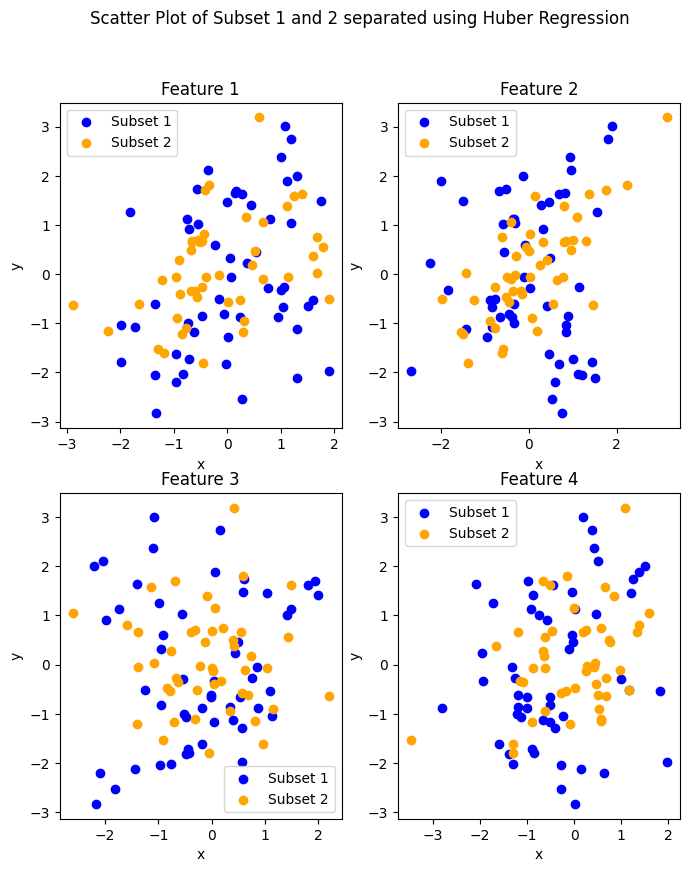

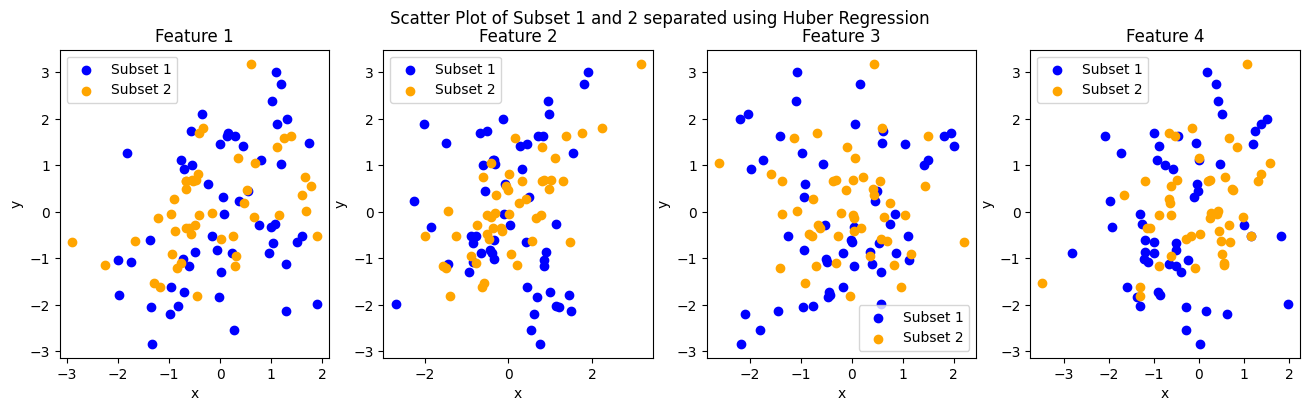

In [67]:
# scatter plots for the huber subsets for each feature

fig, axs = plt.subplots(2, 2,figsize=(8,9.3))
axs[0, 0].scatter(subset1h[:,0],ytrain1h, color='blue', label='Subset 1')
axs[0, 0].scatter(subset2h[:,0],ytrain2h, color='orange', label='Subset 2')
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('y')
axs[0, 0].legend()
axs[0, 0].set_title('Feature 1')
axs[0, 1].scatter(subset1h[:,1],ytrain1h, color='blue', label='Subset 1')
axs[0, 1].scatter(subset2h[:,1],ytrain2h, color='orange', label='Subset 2')
axs[0,1].legend()
axs[0,1].set_xlabel('x')
axs[0,1].set_ylabel('y')
axs[0, 1].set_title('Feature 2')
axs[1, 0].scatter(subset1h[:,2],ytrain1h, color='blue', label='Subset 1')
axs[1, 0].scatter(subset2h[:,2],ytrain2h, color='orange', label='Subset 2')
axs[1,0].legend()
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('y')
axs[1, 0].set_title('Feature 3')
axs[1, 1].scatter(subset1h[:,3],ytrain1h, color='blue', label='Subset 1')
axs[1, 1].scatter(subset2h[:,3],ytrain2h, color='orange', label='Subset 2')
axs[1,1].legend()
axs[1,1].set_xlabel('x')
axs[1,1].set_ylabel('y')
axs[1, 1].set_title('Feature 4')
plt.suptitle('Scatter Plot of Subset 1 and 2 separated using Huber Regression')

# same plot but one line and for columns of plots

fig, axs = plt.subplots(1, 4,figsize=(16,4))
axs[0].scatter(subset1h[:,0],ytrain1h, color='blue', label='Subset 1')
axs[0].scatter(subset2h[:,0],ytrain2h, color='orange', label='Subset 2')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].legend()
axs[0].set_title('Feature 1')
axs[1].scatter(subset1h[:,1],ytrain1h, color='blue', label='Subset 1')
axs[1].scatter(subset2h[:,1],ytrain2h, color='orange', label='Subset 2')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].legend()
axs[1].set_title('Feature 2')
axs[2].scatter(subset1h[:,2],ytrain1h, color='blue', label='Subset 1')
axs[2].scatter(subset2h[:,2],ytrain2h, color='orange', label='Subset 2')
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].legend()
axs[2].set_title('Feature 3')
axs[3].scatter(subset1h[:,3],ytrain1h, color='blue', label='Subset 1')
axs[3].scatter(subset2h[:,3],ytrain2h, color='orange', label='Subset 2')
axs[3].set_xlabel('x')
axs[3].set_ylabel('y')
axs[3].legend()
axs[3].set_title('Feature 4')
plt.suptitle('Scatter Plot of Subset 1 and 2 separated using Huber Regression')



In [26]:
modelreg1 = reg(subset1h,ytrain1h)
modelreg2 = reg(subset2h,ytrain2h)


print("Stats for the first subset")
regstats(subset1h,ytrain1h,modelreg1)
print("\n")

print("Stats for the second subset")
regstats(subset2h,ytrain2h,modelreg2)

# linear regression works well for second subset 

Stats for the first subset
Regression Statistics

The MSE score of the model is: 2.414
The MSE score of the model (using k=5) is: 2.383
The mean r2 (test) score of the best model is: -0.142
The r2 (train) score of the best model is: 0.163


Stats for the second subset
Regression Statistics

The MSE score of the model is: 0.032
The MSE score of the model (using k=5) is: 0.034
The mean r2 (test) score of the best model is: 0.957
The r2 (train) score of the best model is: 0.976


In [27]:
# testing lasso for both

searchlasso1 = lassoalpha(subset1h,ytrain1h,200)
searchlasso2 = lassoalpha(subset2h,ytrain2h,200)

lassostats(subset1h,ytrain1h,searchlasso1)
print("\n")
lassostats(subset2h,ytrain2h,searchlasso2)



The best parameters found is: {'alpha': 0.29331662783900364}
The best parameters found is: {'alpha': 0.001722585965398784}
Lasso Statistics

The mean CV score of the model using the best alpha and LOOCV is: 2.339
The MSE score of the model using the best alpha with CV k=11 is: 2.327
The mean r2 (test) score of the best model is: -0.068
The r2 (train) score of the best model is: 0.057


Lasso Statistics

The mean CV score of the model using the best alpha and LOOCV is: 0.032
The MSE score of the model using the best alpha with CV k=11 is: 0.035
The mean r2 (test) score of the best model is: 0.957
The r2 (train) score of the best model is: 0.976


In [28]:
# testing ridge for both

searchridge1 = ridgebestalpha(subset1h,ytrain1h,200)
searchridge2 = ridgebestalpha(subset2h,ytrain2h,200)

ridgescores(subset1h,ytrain1h,searchridge1)
print("\n")
ridgescores(subset2h,ytrain2h,searchridge2)


The best parameters found are: {'alpha': 75.7525025877192}
The best parameters found are: {'alpha': 0.33700643292719246}
The mean CV score of the model with the best alpha (using LOOCV) is: 2.287
The MSE score of the model using the best alpha with CV k=5 is: 1.453
The mean r2 (test) score of the best model is: 0.097
The r2 (train) score of the best model is: 0.103


The mean CV score of the model with the best alpha (using LOOCV) is: 0.032
The MSE score of the model using the best alpha with CV k=5 is: 1.395
The mean r2 (test) score of the best model is: 0.078
The r2 (train) score of the best model is: 0.976


### Using RANSAC to divide the data into two subsets

In [29]:
# we deleted a line from training so we could use RANSAC and divide the data without it to 
#then check if it was best predicted by its own subset or the other one
xtrainnew = np.delete(xtrain,60,0)
ytrainnew = np.delete(ytrain,60,0)

ransac = RANSACRegressor(estimator=LinearRegression(),loss='squared_error', random_state=0, stop_n_inliers=50).fit(xtrain,ytrain)

# get inlier mask

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# get number of inliers and outliers

print(np.sum(inlier_mask))
print(np.sum(outlier_mask))

# build subsets

subset1_r = xtrain[inlier_mask]
subset2_r = xtrain[outlier_mask]

ytrain1_r = ytrain[inlier_mask]
ytrain2_r = ytrain[outlier_mask]

56
44


In [55]:
# mean and std of each subset

print('Subset 1 mean: ', np.mean(subset1_r, axis=0))
print('Subset 1 std: ', np.std(subset1_r, axis=0))
print('Subset 2 mean: ', np.mean(subset2_r, axis=0))
print('Subset 2 std: ', np.std(subset2_r, axis=0))

Subset 1 mean:  [ 0.00073868 -0.10916644 -0.03165646 -0.40800749]
Subset 1 std:  [0.95201821 0.90312545 0.94799104 0.93614801]
Subset 2 mean:  [-0.04777444  0.25010187 -0.26869221  0.02534916]
Subset 2 std:  [1.13658144 1.14267159 1.08883823 1.04846812]


In [30]:
xtesting = xtrain[60]
ytesting = ytrain[60]

Text(0.5, 0.98, 'Scatter Plot of Subset 1 and 2 separated using RANSAC Regression')

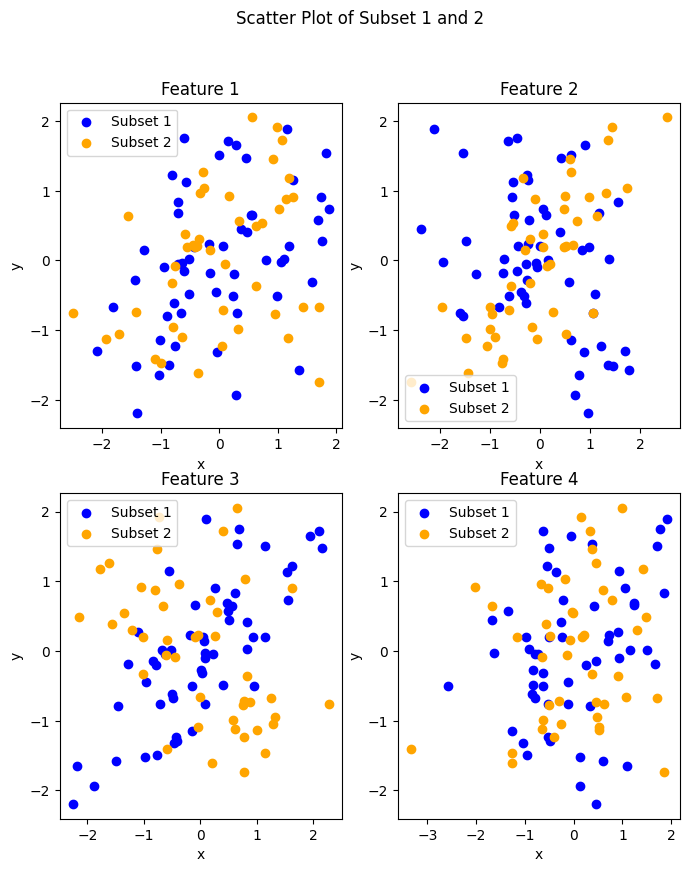

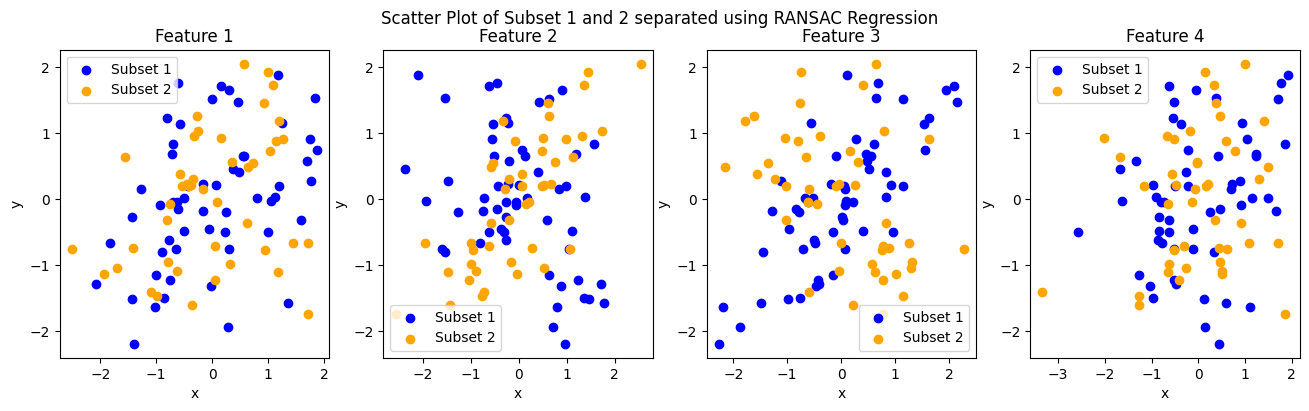

In [68]:
# normalize subsets

subset1_r_norm = (subset1_r - np.mean(subset1_r, axis=0)) / np.std(subset1_r, axis=0)
subset2_r_norm = (subset2_r - np.mean(subset2_r, axis=0)) / np.std(subset2_r, axis=0)
ytrain1_r_norm = (ytrain1_r - np.mean(ytrain1_r, axis=0)) / np.std(ytrain1_r, axis=0)
ytrain2_r_norm = (ytrain2_r - np.mean(ytrain2_r, axis=0)) / np.std(ytrain2_r, axis=0)


fig, axs = plt.subplots(2, 2,figsize=(8,9.3))
axs[0, 0].scatter(subset1_r_norm[:,0],ytrain1_r_norm, color='blue', label='Subset 1')
axs[0, 0].scatter(subset2_r_norm[:,0],ytrain2_r_norm, color='orange', label='Subset 2')
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('y')
axs[0, 0].legend()
axs[0, 0].set_title('Feature 1')
axs[0, 1].scatter(subset1_r_norm[:,1],ytrain1_r_norm, color='blue', label='Subset 1')
axs[0, 1].scatter(subset2_r_norm[:,1],ytrain2_r_norm, color='orange', label='Subset 2')
axs[0,1].legend()
axs[0,1].set_xlabel('x')
axs[0,1].set_ylabel('y')
axs[0, 1].set_title('Feature 2')
axs[1, 0].scatter(subset1_r_norm[:,2],ytrain1_r_norm, color='blue', label='Subset 1')
axs[1, 0].scatter(subset2_r_norm[:,2],ytrain2_r_norm, color='orange', label='Subset 2')
axs[1,0].legend()
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('y')
axs[1, 0].set_title('Feature 3')
axs[1, 1].scatter(subset1_r_norm[:,3],ytrain1_r_norm, color='blue', label='Subset 1')
axs[1, 1].scatter(subset2_r_norm[:,3],ytrain2_r_norm, color='orange', label='Subset 2')
axs[1,1].legend()
axs[1,1].set_xlabel('x')
axs[1,1].set_ylabel('y')
axs[1, 1].set_title('Feature 4')
plt.suptitle('Scatter Plot of Subset 1 and 2')

# same plot but one line and for columns of plots

fig, axs = plt.subplots(1, 4,figsize=(16,4))
axs[0].scatter(subset1_r_norm[:,0],ytrain1_r_norm, color='blue', label='Subset 1')
axs[0].scatter(subset2_r_norm[:,0],ytrain2_r_norm, color='orange', label='Subset 2')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].legend()
axs[0].set_title('Feature 1')
axs[1].scatter(subset1_r_norm[:,1],ytrain1_r_norm, color='blue', label='Subset 1')
axs[1].scatter(subset2_r_norm[:,1],ytrain2_r_norm, color='orange', label='Subset 2')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].legend()
axs[1].set_title('Feature 2')
axs[2].scatter(subset1_r_norm[:,2],ytrain1_r_norm, color='blue', label='Subset 1')
axs[2].scatter(subset2_r_norm[:,2],ytrain2_r_norm, color='orange', label='Subset 2')
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].legend()
axs[2].set_title('Feature 3')
axs[3].scatter(subset1_r_norm[:,3],ytrain1_r_norm, color='blue', label='Subset 1')
axs[3].scatter(subset2_r_norm[:,3],ytrain2_r_norm, color='orange', label='Subset 2')
axs[3].set_xlabel('x')
axs[3].set_ylabel('y')
axs[3].legend()
axs[3].set_title('Feature 4')
plt.suptitle('Scatter Plot of Subset 1 and 2 separated using RANSAC Regression')



#### Chosen model: Training 2 Linear Regressions with the Subsets separated from RANSAC

In [57]:
# linear regression for both 

modelreg1_r = reg(subset1_r,ytrain1_r)
modelreg2_r = reg(subset2_r,ytrain2_r)

print("Stats for the first subset")
regstats(subset1_r,ytrain1_r,modelreg1_r)
print("\n")

print("Stats for the second subset")
regstats(subset2_r,ytrain2_r,modelreg2_r)


Stats for the first subset
Regression Statistics

The MSE score of the model is: 0.116
The MSE score of the model (using k=5) is: 0.116
The mean r2 (test) score of the best model is: 0.883
The r2 (train) score of the best model is: 0.926


Stats for the second subset
Regression Statistics

The MSE score of the model is: 0.065
The MSE score of the model (using k=5) is: 0.062
The mean r2 (test) score of the best model is: 0.956
The r2 (train) score of the best model is: 0.974


In [33]:
# get each regression coefs

print("Regression Coefs for the first subset")
regcoefs(modelreg1_r)
print("\n")

print("Regression Coefs for the second subset")
regcoefs(modelreg2_r)


Regression Coefs for the first subset
[[ 0.11156131 -0.43013619  1.02306495  0.59269036]]


Regression Coefs for the second subset
[[ 0.53400164  1.03370736 -0.4716468   0.0971299 ]]


Text(0.5, 0.98, 'Scatter Plot with the Chosen Regression line of Subset 1 and 2')

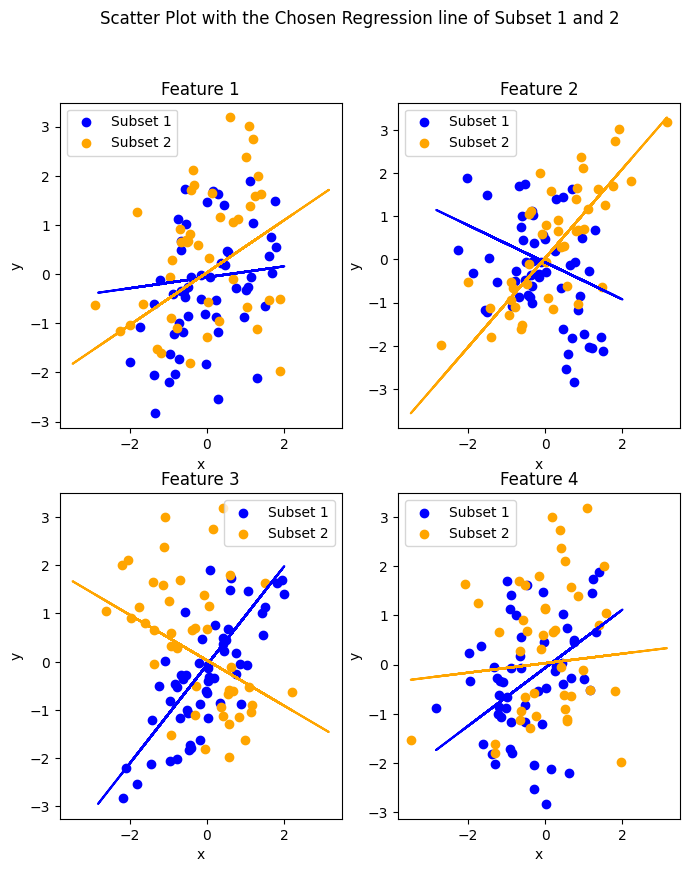

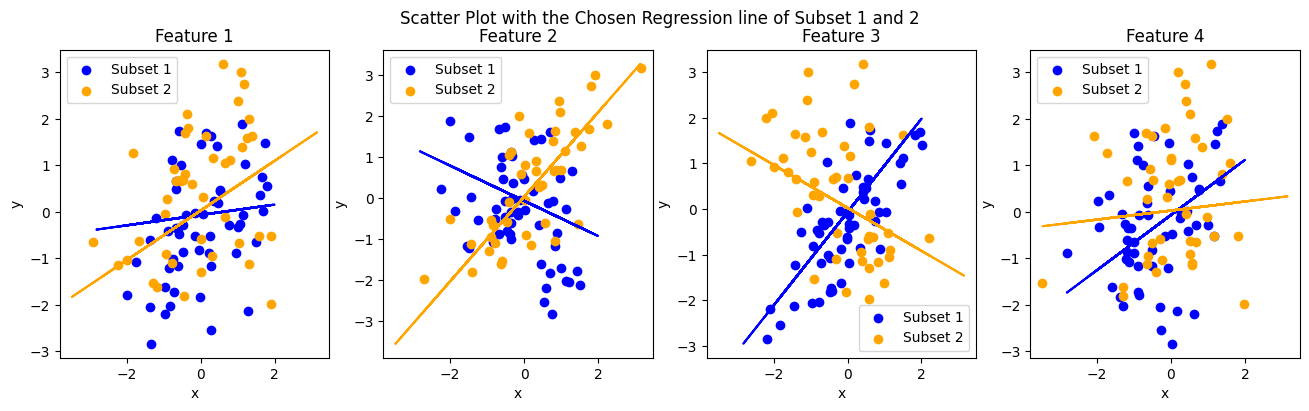

In [64]:
# non normalized scatter plots

fig, axs = plt.subplots(2, 2,figsize=(8,9.3))
axs[0, 0].scatter(subset1_r[:,0],ytrain1_r, color='blue', label='Subset 1')
axs[0, 0].scatter(subset2_r[:,0],ytrain2_r, color='orange', label='Subset 2')
axs[0,0].plot(subset1_r,modelreg1_r.coef_[0][0]*subset1_r + modelreg1_r.intercept_[0], color='blue')
axs[0,0].plot(subset2_r,modelreg2_r.coef_[0][0]*subset2_r + modelreg2_r.intercept_[0], color='orange')
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('y')
axs[0, 0].legend()
axs[0, 0].set_title('Feature 1')
axs[0, 1].scatter(subset1_r[:,1],ytrain1_r, color='blue', label='Subset 1')
axs[0, 1].scatter(subset2_r[:,1],ytrain2_r, color='orange', label='Subset 2')
axs[0,1].plot(subset1_r,modelreg1_r.coef_[0][1]*subset1_r + modelreg1_r.intercept_[0],  color='blue')
axs[0,1].plot(subset2_r,modelreg2_r.coef_[0][1]*subset2_r + modelreg2_r.intercept_[0], color='orange')
axs[0,1].legend()
axs[0,1].set_xlabel('x')
axs[0,1].set_ylabel('y')
axs[0, 1].set_title('Feature 2')
axs[1, 0].scatter(subset1_r[:,2],ytrain1_r, color='blue', label='Subset 1')
axs[1, 0].scatter(subset2_r[:,2],ytrain2_r, color='orange', label='Subset 2')
axs[1,0].plot(subset1_r,modelreg1_r.coef_[0][2]*subset1_r + modelreg1_r.intercept_[0], color='blue')
axs[1,0].plot(subset2_r,modelreg2_r.coef_[0][2]*subset2_r + modelreg2_r.intercept_[0], color='orange')
axs[1,0].legend()
axs[1,0].set_xlabel('x')
axs[1,0].set_ylabel('y')
axs[1, 0].set_title('Feature 3')
axs[1, 1].scatter(subset1_r[:,3],ytrain1_r, color='blue', label='Subset 1')
axs[1, 1].scatter(subset2_r[:,3],ytrain2_r, color='orange', label='Subset 2')
axs[1,1].plot(subset1_r,modelreg1_r.coef_[0][3]*subset1_r + modelreg1_r.intercept_[0], color='blue')
axs[1,1].plot(subset2_r,modelreg2_r.coef_[0][3]*subset2_r + modelreg2_r.intercept_[0], color='orange')
axs[1,1].legend()
axs[1,1].set_xlabel('x')
axs[1,1].set_ylabel('y')
axs[1, 1].set_title('Feature 4')
plt.suptitle('Scatter Plot with the Chosen Regression line of Subset 1 and 2')

# scatter plots but in a single line subplot and with dashed regression lines

fig, axs = plt.subplots(1, 4,figsize=(16,4))
axs[0].scatter(subset1_r[:,0],ytrain1_r, color='blue', label='Subset 1')
axs[0].scatter(subset2_r[:,0],ytrain2_r, color='orange', label='Subset 2')
axs[0].plot(subset1_r,modelreg1_r.coef_[0][0]*subset1_r + modelreg1_r.intercept_[0], color='blue')
axs[0].plot(subset2_r,modelreg2_r.coef_[0][0]*subset2_r + modelreg2_r.intercept_[0], color='orange')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].legend()
axs[0].set_title('Feature 1')
axs[1].scatter(subset1_r[:,1],ytrain1_r, color='blue', label='Subset 1')
axs[1].scatter(subset2_r[:,1],ytrain2_r, color='orange', label='Subset 2')
axs[1].plot(subset1_r,modelreg1_r.coef_[0][1]*subset1_r + modelreg1_r.intercept_[0],  color='blue')
axs[1].plot(subset2_r,modelreg2_r.coef_[0][1]*subset2_r + modelreg2_r.intercept_[0], color='orange')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].legend()
axs[1].set_title('Feature 2')
axs[2].scatter(subset1_r[:,2],ytrain1_r, color='blue', label='Subset 1')
axs[2].scatter(subset2_r[:,2],ytrain2_r, color='orange', label='Subset 2')
axs[2].plot(subset1_r,modelreg1_r.coef_[0][2]*subset1_r + modelreg1_r.intercept_[0], color='blue')
axs[2].plot(subset2_r,modelreg2_r.coef_[0][2]*subset2_r + modelreg2_r.intercept_[0], color='orange')
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].legend()
axs[2].set_title('Feature 3')
axs[3].scatter(subset1_r[:,3],ytrain1_r, color='blue', label='Subset 1')
axs[3].scatter(subset2_r[:,3],ytrain2_r, color='orange', label='Subset 2')
axs[3].plot(subset1_r,modelreg1_r.coef_[0][3]*subset1_r + modelreg1_r.intercept_[0], color='blue')
axs[3].plot(subset2_r,modelreg2_r.coef_[0][3]*subset2_r + modelreg2_r.intercept_[0], color='orange')
axs[3].set_xlabel('x')
axs[3].set_ylabel('y')
axs[3].legend()
axs[3].set_title('Feature 4')
plt.suptitle('Scatter Plot with the Chosen Regression line of Subset 1 and 2')

In [35]:
# get ytest from modelreg1_r

ytest1 = modelreg1_r.predict(xtest)
print(ytest1.shape)

# get ytest from modelreg2_r

ytest2 = modelreg2_r.predict(xtest)
print(ytest2.shape)

# build submission matrix

ytest = np.column_stack((ytest1,ytest2))
print(ytest.shape)

# save submission matrix

np.save("y_test.npy", ytest)


(1000, 1)
(1000, 1)
(1000, 2)


In [36]:
# ridge for both

searchridge1_r = ridgebestalpha(subset1_r,ytrain1_r,200)
searchridge2_r = ridgebestalpha(subset2_r,ytrain2_r,200)

ridgescores(subset1_r,ytrain1_r,searchridge1_r)
print("\n")
ridgescores(subset2_r,ytrain2_r,searchridge2_r)

The best parameters found are: {'alpha': 1e-10}
The best parameters found are: {'alpha': 0.25529080682395167}
The mean CV score of the model with the best alpha (using LOOCV) is: 0.116
The MSE score of the model using the best alpha with CV k=5 is: 1.396
The mean r2 (test) score of the best model is: 0.077
The r2 (train) score of the best model is: 0.926


The mean CV score of the model with the best alpha (using LOOCV) is: 0.065
The MSE score of the model using the best alpha with CV k=5 is: 1.395
The mean r2 (test) score of the best model is: 0.078
The r2 (train) score of the best model is: 0.974


In [69]:
searhlasso_r = lassoalpha(subset1_r,ytrain1_r,200)
searchlasso2_r = lassoalpha(subset2_r,ytrain2_r,200)

lassostats(subset1_r,ytrain1_r,searhlasso_r)
print("\n")
lassostats(subset2_r,ytrain2_r,searchlasso2_r)


The best parameters found is: {'alpha': 6.294988990221888e-07}
The best parameters found is: {'alpha': 0.00014149912974345758}
Lasso Statistics

The mean CV score of the model using the best alpha and LOOCV is: 0.116
The MSE score of the model using the best alpha with CV k=11 is: 0.116
The mean r2 (test) score of the best model is: 0.883
The r2 (train) score of the best model is: 0.926


Lasso Statistics

The mean CV score of the model using the best alpha and LOOCV is: 0.065
The MSE score of the model using the best alpha with CV k=11 is: 0.062
The mean r2 (test) score of the best model is: 0.956
The r2 (train) score of the best model is: 0.974


In [37]:
# optimizing ransac with lasso

#ransac_lasso = RANSACRegressor(estimator=Lasso(alpha=0.008),loss='squared_error', random_state=0, stop_n_inliers=50, min_samples=30).fit(xtrain,ytrain_f)

# get inlier mask

#inlier_mask_lasso = ransac_lasso.inlier_mask_
#outlier_mask_lasso = np.logical_not(inlier_mask_lasso)

# get number of inliers and outliers

#print(np.sum(inlier_mask_lasso))
#print(np.sum(outlier_mask_lasso))

# build subsets

#subset1_r_lasso = xtrain[inlier_mask_lasso]
#subset2_r_lasso = xtrain[outlier_mask_lasso]

#ytrain1_r_lasso = ytrain[inlier_mask_lasso]
#ytrain2_r_lasso = ytrain[outlier_mask_lasso]


# lasso for both

#searchlasso1_r = lassoalpha(subset1_r_lasso,ytrain1_r_lasso,200)
#searchlasso2_r = lassoalpha(subset2_r_lasso,ytrain2_r_lasso,200)

#lassostats(subset1_r_lasso,ytrain1_r_lasso,searchlasso1_r)
#print("\n")

#lassostats(subset2_r_lasso,ytrain2_r_lasso,searchlasso2_r)
